# Manual 06: Optimización No lineal, Riesgo Dualidad
## Universidad del Norte
### Economía Matemática
Llegó la hora de ir cerrando el curso. En esta ocasión mostraremos algunas generalidades de Kuhn Tucker, propiedades de la Microeconomía con sus funciones de Utilidad, riesgo y un poco de probabilidad

Empecemos con una función básica cuadratica:

In [1]:
import numpy as np
from scipy.optimize import minimize

# Definir la función objetivo
def funcion_objetivo(x):
    return x[0]**2 + x[1]**2 + x[0]*x[1]

# Definir las restricciones
# Restricción de igualdad: x0 + x1 = 1
restricciones = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1})

# Suposición inicial (punto de partida)
x_inicial = np.array([0.5, 0.5])

# Ejecutar la optimización
resultado = minimize(funcion_objetivo, x_inicial, constraints=restricciones)

# Mostrar los resultados
print('Valor óptimo de la función:', resultado.fun)
print('Solución óptima:', resultado.x)

Valor óptimo de la función: 0.75
Solución óptima: [0.5 0.5]


### Modelo Cobb Douglas (No líneal)
Empezamos con el modelo tradicional de Cobb-Douglas. El porqué de uso se debe simplemente a que es la primera expresión en la microeconomía que no es lineal.

In [2]:
import numpy as np
from scipy.optimize import minimize

# Función objetivo (negamos utilidad porque minimize minimiza)
def utilidad_neg(x):
    return - (x[0]**0.5) * (x[1]**0.5)

# Restricción: 5x + 10y = 100
restriccion = {
    'type': 'eq',
    'fun': lambda x: 5*x[0] + 10*x[1] - 100
}

# Cotas: no podemos consumir cantidades negativas
bounds = [(0, None), (0, None)]

# Punto inicial
x0 = [1, 1]

# Minimización
resultado = minimize(utilidad_neg, x0, method='SLSQP', bounds=bounds, constraints=[restriccion])

# Mostrar resultados
print("¿Éxito en la optimización?", resultado.success)
print("Mensaje:", resultado.message)
print("Solución óptima (x, y):", resultado.x)
print("Utilidad máxima alcanzada:", -resultado.fun)

¿Éxito en la optimización? True
Mensaje: Optimization terminated successfully
Solución óptima (x, y): [9.99985483 5.00007259]
Utilidad máxima alcanzada: 7.0710678111203835


## Dualidad

Luego de encontrar las soluciones optimas podriamos incursionar en lo que hace referencia a las demandas compensadas o "Hicksianas". Para encontrarlas vamos a tener entonces ahora que:

In [3]:
import numpy as np
from scipy.optimize import minimize

# Nivel de utilidad objetivo
U_bar = 7.07  # el valor obtenido en el problema primal

# Función de gasto
def gasto(x):
    return 5*x[0] + 10*x[1]

# Restricción de utilidad
restriccion = {
    'type': 'ineq',  # forma: f(x) >= 0
    'fun': lambda x: (x[0]**0.5)*(x[1]**0.5) - U_bar
}

# Cotas: consumos positivos
bounds = [(0, None), (0, None)]

# Punto inicial
x0 = [1, 1]

# Minimización
resultado = minimize(gasto, x0, method='SLSQP', bounds=bounds, constraints=[restriccion])

# --- Extraer y redondear resultados ---
solucion = np.round(resultado.x, 2)
valor_optimo = round(-resultado.fun, 2)  # cambiamos el signo y redondeamos

# Mostrar resultados
print("¿Éxito en la optimización?", resultado.success)
print("Mensaje:", resultado.message)
print("Consumo óptimo (x, y):", solucion)
print("Gasto mínimo requerido:", valor_optimo)

¿Éxito en la optimización? True
Mensaje: Optimization terminated successfully
Consumo óptimo (x, y): [10.  5.]
Gasto mínimo requerido: -99.98


> El método de `SLSP` se llama Sequential Least Squares Programming: programa cuadrático en secuencia. Se usa porque linealiza la función objetivo y las restricciones en cada iteración (alrededor del punto actual).Ademas, resuelve un subproblema cuadrático (de mínimos cuadrados) con esas aproximaciones lineales. Actualiza la solución y repite hasta converger en un punto.

A continuación vamos a mirar la "identidad de Roy". Con una función de Utilidad Indirecta como $V(m, p_x, p_y)$. Derivando con respecto a cada uno de los precios. Alcanzamos las demandas Marshallianas

In [4]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import approx_fprime

# Parámetros
alpha = 0.5
p = np.array([5, 10])  # precios px, py
I = 100                # ingreso

# Utilidad directa
def utilidad(x):
    return x[0]**alpha * x[1]**(1 - alpha)

# Utilidad indirecta (resolver problema primal)
def v(p1, p2, I):
    def neg_util(x):
        return -utilidad(x)
    
    restriccion = {'type': 'eq', 'fun': lambda x: p1*x[0] + p2*x[1] - I}
    bounds = [(0, None), (0, None)]
    x0 = [1, 1]
    res = minimize(neg_util, x0, method='SLSQP', bounds=bounds, constraints=[restriccion])
    return -res.fun

# Envoltorio de utilidad indirecta para derivar
def v_vector(x):
    return v(x[0], x[1], x[2])

# Punto para evaluar derivadas: (p1, p2, I)
p_eval = np.array([5.0, 10.0, 100.0])

# Derivadas numéricas
eps = np.sqrt(np.finfo(float).eps)
grad_v = approx_fprime(p_eval, v_vector, eps)

# Identidad de Roy (para x y)
x_roy = -grad_v[0] / grad_v[2]
y_roy = -grad_v[1] / grad_v[2]

# Resultado
print("Demanda según Identidad de Roy:")
print(f"x (via Roy): {x_roy:.4f}")
print(f"y (via Roy): {y_roy:.4f}")
print(f"Verificación: px*x + py*y = {p[0]*x_roy + p[1]*y_roy:.2f} ≈ {I}")

Demanda según Identidad de Roy:
x (via Roy): 9.7864
y (via Roy): 4.9570
Verificación: px*x + py*y = 98.50 ≈ 100


Notamos que sensibilizando cada uno de los valores. De un resultado general regresamos sin necesidad de aplicar el Lagrangiano, las demandas optimas del problema general. En Microeconomía Avanzada son muy utilizadas

------

## Algo de Riesgo

Es bueno tenerlo presente. Ya que nos permite definir algunas estrategias cuando buscamos elegir optimamente algo.

Tabla de resultados:

   Resultado  Probabilidad  Utilidad
0        100           0.5      10.0
1         25           0.5       5.0

--- Resultados clave ---
Valor esperado: 62.50
Utilidad esperada: 7.5000
Utilidad del valor esperado: 7.9057
Prima de riesgo: 0.0000


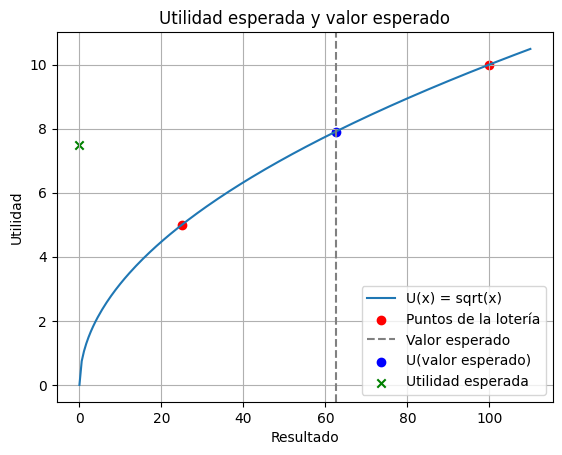

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Función de utilidad (concava: agente averso al riesgo) ---
def utilidad(x):
    return np.sqrt(x)  # U(x) = sqrt(x)

# --- Datos de la lotería ---
# Dos resultados posibles: ganar 100 o ganar 25, cada uno con 50%
resultados = np.array([100, 25])
probabilidades = np.array([0.5, 0.5])

# --- Cálculos principales ---
valor_esperado = np.dot(resultados, probabilidades)

utilidades = utilidad(resultados)
utilidad_esperada = np.dot(utilidades, probabilidades)

utilidad_valor_esperado = utilidad(valor_esperado)

# Prima de riesgo: cuánto estaría dispuesto a pagar para evitar el riesgo
prima_riesgo = valor_esperado - (utilidad_valor_esperado)**2

# --- Mostrar resultados en tabla ---
df = pd.DataFrame({
    "Resultado": resultados,
    "Probabilidad": probabilidades,
    "Utilidad": utilidades
})

print("Tabla de resultados:\n")
print(df)

print("\n--- Resultados clave ---")
print(f"Valor esperado: {valor_esperado:.2f}")
print(f"Utilidad esperada: {utilidad_esperada:.4f}")
print(f"Utilidad del valor esperado: {utilidad_valor_esperado:.4f}")
print(f"Prima de riesgo: {prima_riesgo:.4f}")

# --- Gráfico para ilustrar ---
x_vals = np.linspace(0, 110, 200)
plt.plot(x_vals, utilidad(x_vals), label="U(x) = sqrt(x)")
plt.scatter(resultados, utilidades, color='red', label="Puntos de la lotería")
plt.axvline(valor_esperado, color='gray', linestyle='--', label="Valor esperado")
plt.scatter([valor_esperado], [utilidad_valor_esperado], color='blue', label="U(valor esperado)")
plt.scatter([0], [utilidad_esperada], color='green', label="Utilidad esperada", marker='x')

plt.title("Utilidad esperada y valor esperado")
plt.xlabel("Resultado")
plt.ylabel("Utilidad")
plt.legend()
plt.grid(True)
plt.show()

## Probabilidad

Es tambien adecuado no dejar de pensar en formatos que incluyen la incertidumbre y que son buenos para tener en cuenta. Piense en un momento en el ejemplo tradicional de Monty Hall. Acá haremos una estrategia de lo que ocurre cuando se cambia de puerta en el programa de TV y cuya manera de ganar es:

Cambiar de puerta gana el 67.28% de las veces.
Quedarse con la puerta inicial gana el 32.72% de las veces.


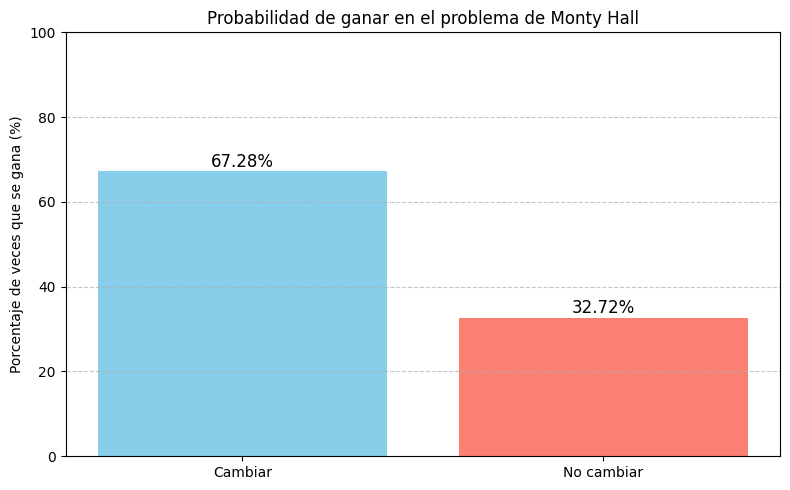

In [6]:
import random
import matplotlib.pyplot as plt

# --- Función para simular una partida del problema de Monty Hall ---
def simulacion_monty_hall():
    # Inicializar las puertas: una tiene un auto, dos tienen cabras
    puertas = ['auto', 'cabra', 'cabra']
    random.shuffle(puertas)
    
    # Elección inicial del concursante (al azar)
    eleccion_inicial = random.choice([0, 1, 2])
    
    # Monty revela una cabra en una de las otras puertas
    for i in range(3):
        if i != eleccion_inicial and puertas[i] == 'cabra':
            cabra_revelada = i
            break
    
    # El concursante decide cambiar de puerta
    cambiar = True  # siempre cambia en esta simulación
    
    # Determinar la elección final
    if cambiar:
        eleccion_final = 3 - eleccion_inicial - cabra_revelada
    else:
        eleccion_final = eleccion_inicial
    
    # Retornar True si ganó el auto, False si ganó una cabra
    return puertas[eleccion_final] == 'auto'

# --- Ejecutar múltiples simulaciones ---
num_simulaciones = 10000
ganadas_cambiando = 0
ganadas_quedandose = 0

for _ in range(num_simulaciones):
    if simulacion_monty_hall():
        ganadas_cambiando += 1
    else:
        ganadas_quedandose += 1

# --- Calcular porcentajes ---
porcentaje_cambio = (ganadas_cambiando / num_simulaciones) * 100
porcentaje_quedarse = (ganadas_quedandose / num_simulaciones) * 100

# --- Mostrar resultados en consola ---
print(f"Cambiar de puerta gana el {porcentaje_cambio:.2f}% de las veces.")
print(f"Quedarse con la puerta inicial gana el {porcentaje_quedarse:.2f}% de las veces.")

# --- Gráfico de barras comparativo ---
etiquetas = ['Cambiar', 'No cambiar']
valores = [porcentaje_cambio, porcentaje_quedarse]
colores = ['skyblue', 'salmon']

plt.figure(figsize=(8, 5))
plt.bar(etiquetas, valores, color=colores)
plt.ylim(0, 100)
plt.title('Probabilidad de ganar en el problema de Monty Hall')
plt.ylabel('Porcentaje de veces que se gana (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de texto encima de las barras
plt.text(0, porcentaje_cambio + 1, f"{porcentaje_cambio:.2f}%", ha='center', fontsize=12)
plt.text(1, porcentaje_quedarse + 1, f"{porcentaje_quedarse:.2f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

---------------------

### Agradecimientos
A todos los profesores que de alguna manera con su material brindaron apoyo para el desarrollo de este curso. El crédito en esta ocasión se le da a Gaurav Kumar.